## Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the use of DR-COSARC on real data sets.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)
suppressMessages(library(hdf5r))

## Load the data

In [2]:
source("../conf_surv/utils_real_data.R")

# Available datasets:
# VALCT: Lung cancer trial data (137 obs, 6 vars, from survival::veteran).
# PBC: Liver disease data (137 obs, 6 vars, from survival::pbc, NAs imputed).
# GBSG: Breast cancer data (2232 obs, 7 vars, combined train/test).
# METABRIC: Breast cancer clinical data (1981 obs, 26 vars).

data <- load_data("GBSG")

dim(data)

# Data features
num_features <- ncol(data) - 2

[1] 2232    9

In [3]:
# Split the dataset
split_result <- split_data(data, train_prop = 0.6, cal_prop = 0.2, test_prop = 0.2, seed = 123)

# Access subsets
data.train <- split_result$train
data.cal <- split_result$cal
data.test <- split_result$test

## Explore the data

In [4]:
# Summarize data under type-I censoring
data.train |>
    summarise(Observations=n(), Events = sum(status), 
              `Proportion censored`=mean(status==0),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]))

Observations,Events,Proportion censored,Median observed time,Median observed event time
<int>,<int>,<dbl>,<dbl>,<dbl>
1339,763,0.4301718,40.14784,16.55852


We can also plot the Kaplan-Meier curve

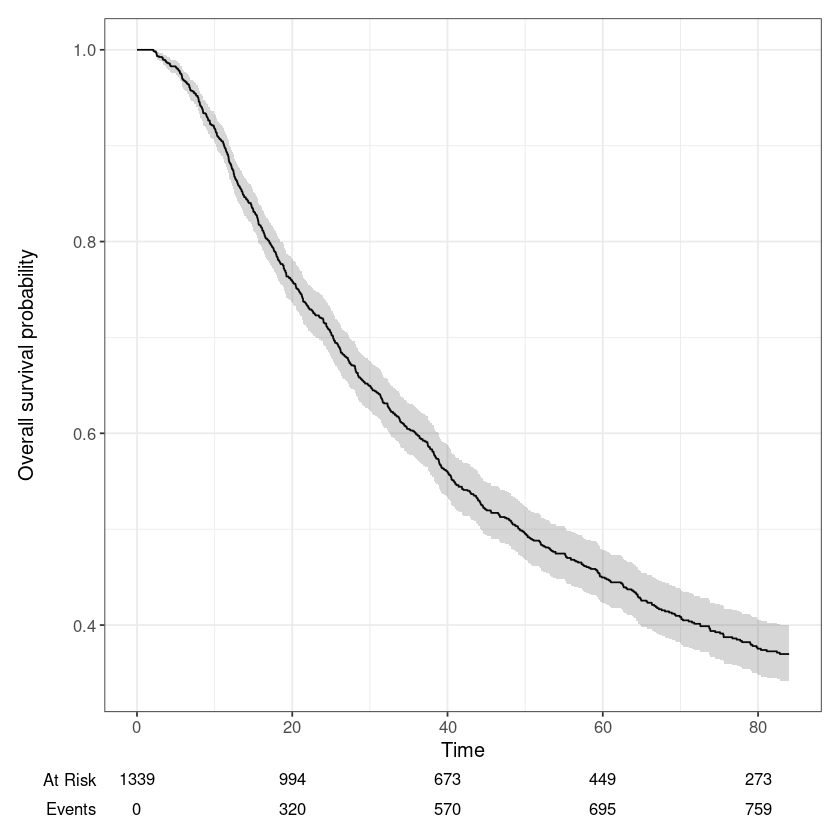

In [5]:
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Training (survival model)

Fit a survival model using the training data.

In [6]:
source("../conf_surv/utils_survival.R")

model_type = "grf"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="lognormal")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else if (model_type=="cox") {
    # Instantiate random forest survival model
    surv_model <- CoxphModelWrapper$new()
} else {
    stop("Unknown model type!")
}

surv_model$fit(Surv(time, status) ~ ., data = data.train)

Let us now visualize the predicted survival curves for two individuals.

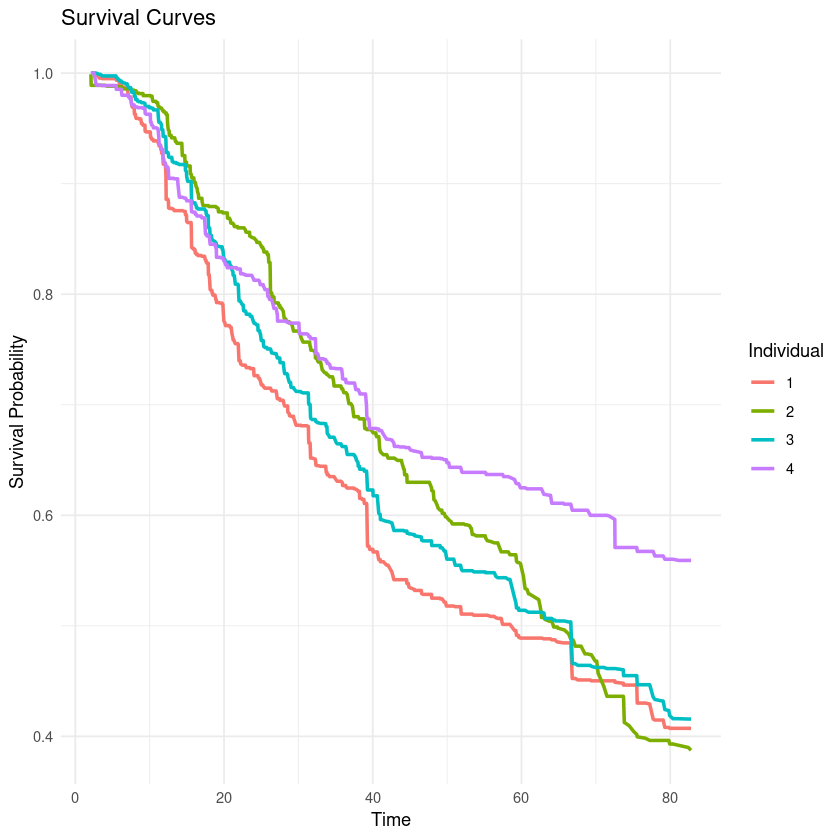

In [7]:
source("../conf_surv/utils_plotting.R")

idx.predict <- c(1:4)
predictions = surv_model$predict(data.cal[idx.predict,])
plot_survival_curves(predictions)

Predict survival time quantiles

In [8]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,12.22177,59.07187,82.79261
Individual_2,16.26283,64.32854,82.79261
Individual_3,15.60575,66.82546,82.79261
Individual_4,13.79877,82.79261,82.79261


## Training (censoring model)

Let's start by visualizing the true censoring distribution

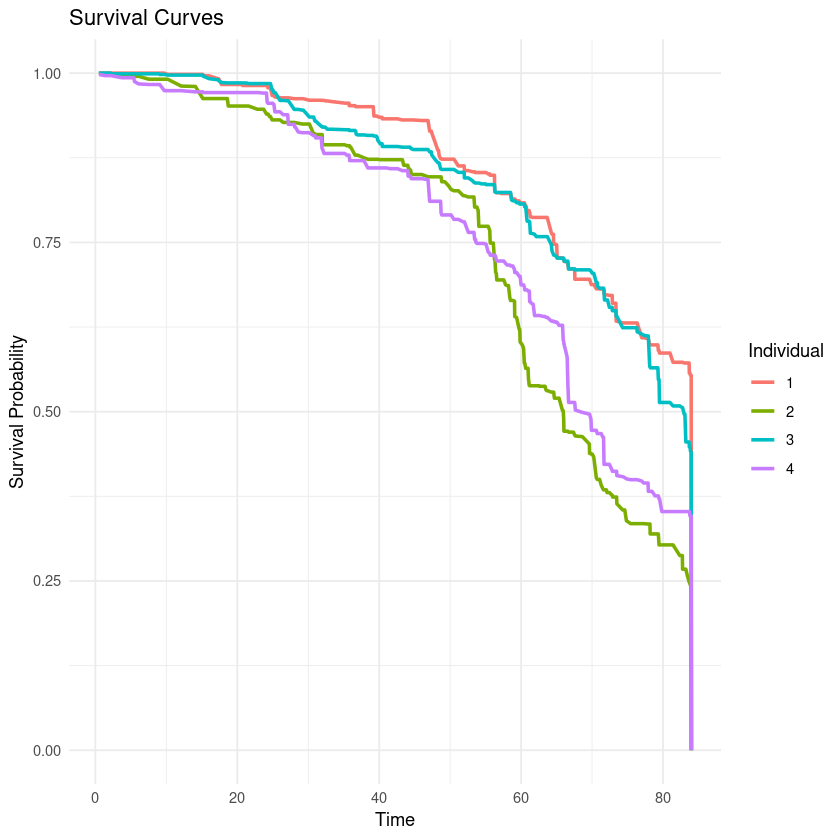

In [9]:
source("../conf_surv/utils_censoring.R")

# List of covariates to use for censoring model
# If we have prior information that some covariates are useless, we can drop them. This helps avoid overfitting, improving the performance of our prototype.
num_feat_censor <- 10
use.covariates <- paste("X",1:min(num_features,num_feat_censor),sep="")

# Initialize a base model for the censoring distribution
cens_base_model <- GRF_SurvivalForestWrapper$new(use_covariates=use.covariates)
#cens_base_model <- SurvregModelWrapper$new(dist="lognormal", use_covariates=use.covariates)
#cens_base_model <- CoxphModelWrapper$new(use_covariates=use.covariates)
#cens_base_model <- randomForestSRC_SurvivalWrapper$new(use_covariates=use.covariates)

# Create an instance of the CensoringModel class with the model
cens_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
cens_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1:4)
pred_surv = cens_model$model$predict(data.cal[idx.predict,])
plot_survival_curves(pred_surv)

## Constructing lower prediction bounds with different methods

In [10]:
source("../conf_surv/utils_conformal.R")

# Nominal level
alpha <- 0.1

In [11]:
# No calibration (trust the survival model's output)
pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.nominal,
                status=data.test$status,
                method="None")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
None,13.23157,NA,0.8680089,0.8903803


In [12]:
# Naive CQR
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr,
                status=data.test$status,
                method="Naive CQR")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Naive CQR,13.03445,NA,0.8680089,0.8903803


In [13]:
source("../conf_surv/utils_decensoring.R")

## Fit the Kaplan-Meier survival model
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)
km_fit <- survfit(surv_object ~ 1)

# Qi et al.'s method (CQR with KM decensoring)
pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test$time, 
                pred.decensor,
                status=data.test$status,
                method="Qi et al.")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Qi et al.,14.08578,NA,0.8501119,0.8747204


In [14]:
# Prototype (combined with Gui's approach)
pred.proto <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, 
                                cutoffs="adaptive")

evaluate_bounds(data.test$time, 
                pred.proto,
                status=data.test$status,
                method="Prototype (Gui)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Prototype (Gui),13.23157,NA,0.8680089,0.8903803


In [15]:
# Prototype (combined with Candes' approach)
pred.proto.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha,
                                       cutoffs="candes-fixed")

evaluate_bounds(data.test$time, 
                pred.proto.candes,
                status=data.test$status,
                method="Prototype (Candes)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
Prototype (Candes),13.23157,NA,0.8680089,0.8903803


## Run simple experiments

In [16]:
analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Initialize the censoring model
    cens_model <- CensoringModel$new(model = cens_base_model)
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        predictions$oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]
    }
    
    # Construct nominal lower bound
    predictions$nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    
    # Apply naive CQR
    predictions$cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR with de-censoring (Qi et al.)
    predictions$cqr.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
       
    # Apply prototype (Gui)
    predictions$prototype.gui <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

    # Apply prototype (Candes)
    predictions$prototype.candes <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")
    
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, censoring_model)

In [17]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, predictions[[name]], status=data.test$status,)
    
  cbind(Method = name, res)
}))
results

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<lgl>,<dbl>,<dbl>
nominal,13.22827,NA,0.8657718,0.8859060
cqr,12.96543,NA,0.8724832,0.8926174
cqr.decensor,14.34531,NA,0.8501119,0.8747204
prototype.gui,13.22827,NA,0.8657718,0.8859060
prototype.candes,13.22827,NA,0.8657718,0.8859060
